In [236]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.cross_validation import KFold


import matplotlib.pyplot as plt


import pandas
import os

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

In [237]:
feature_file   = "data/words_sentences/brent_srilm_features.csv"
my_data = pandas.read_csv(feature_file)

my_data = my_data.dropna()
my_data = my_data.reset_index(drop=True)
my_data = my_data

# y will be the same for all feature sets, so we can define it here globally
y       = preprocessing.scale(my_data["y"])


/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [238]:
def plot(x, y, regression, labels=[]):
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Data')
    ax.scatter(x, y)

    ax.plot(x, regression, label='regression line', lw=2.)
    
    if len(labels) == len(x):
        for ll, x, y in zip(labels, x, y):
            plt.annotate(
                ll,
                fontsize=4,
                xy=(x, y), xytext=(0, 1),
                textcoords='offset points', ha='right', va='bottom')

    plt.legend(loc=0)
    fig.show()
    plt.close(fig)

In [239]:
def regress(method,xtrain,ytrain,xtest,ytest,features):
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    reg.fit(xtrain, ytrain)

    y_predict  = reg.predict(xtest)

    mmse = np.mean((y_predict - ytest) ** 2)
    r2  = reg.score(xtest, ytest)
    
    if len(features) == 1:
        plot(xtrain, ytrain, reg.predict(xtrain))
        
    return mmse, r2, reg.coef_

In [240]:
def regress_cv(method,xx,yy,features,n_folds=10,seed=5):
    
    #fix seed for reproducability
    np.random.seed(seed)
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    cv_mse    = 0.0
    cv_r2 = 0.0
    
    for ii in range(n_folds):
        
        # split in 90% train and 10%test
        mask =  np.random.rand(len(xx)) < 0.9
        
        this_xtrain = xx[mask]
        this_xtest  = xx[~mask]
        this_ytrain = yy[mask]
        this_ytest  = yy[~mask]

        
        reg.fit(this_xtrain, this_ytrain)

        y_predict  = reg.predict(this_xtest)

        mse = np.mean((y_predict - this_ytest) ** 2)
        r2  = reg.score(this_xtest, this_ytest)
    
        cv_mse += mse
        cv_r2 += r2
        
        if len(features) == 1:
            plot(this_xtrain, this_ytrain, reg.predict(this_xtrain))
    
    
    return cv_mse/float(n_folds), cv_r2/float(n_folds), reg.coef_

/usr/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


['freq'] 0.990160731661
['freq', 'w1'] 0.987404740944
['freq', 'w1w2'] 0.982968872137
['freq', 'p0w1'] 0.97850032914
['freq', 'p0w1w2'] 0.979896506529
['freq', 'p0p1w1'] 0.978479432433
['freq', 'p0p1w1w2'] 0.979671226739
['freq', 'w1', 'w1w2'] 0.983941263966
['freq', 'p0w1', 'p0w1w2'] 0.978134953712
['freq', 'p0p1w1', 'p0p1w1w2'] 0.978222353986
['freq', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.978304835806
['freq', 'w1', 'w1w2', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.974409038166


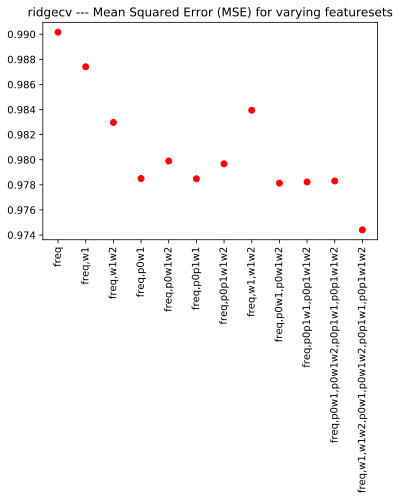

In [241]:
featuresets = [['freq'], ['freq','w1'], ['freq','w1w2'], 
               ['freq','p0w1'], ['freq','p0w1w2'], ['freq','p0p1w1'],
               ['freq','p0p1w1w2'], 
               ['freq','w1','w1w2'],
               ['freq','p0w1','p0w1w2'],
               ['freq','p0p1w1','p0p1w1w2'],
               ['freq','p0w1','p0w1w2','p0p1w1','p0p1w1w2'],
               ['freq','w1','w1w2','p0w1','p0w1w2','p0p1w1','p0p1w1w2']]

method      = "ridgecv" # options: "linear" ridge" "ridgecv"

mses = []

for features in featuresets:
    
    
    this_x_train       = preprocessing.scale(np.log(my_data[features]))
#    this_x_test        = preprocessing.scale(np.log(my_data[features]))[255:]
    
    
#    mse, r2, coefs = regress(method,this_x_train,y[:255],this_x_test,y[255:],features)
    mse, r2, last_coefs      = regress_cv(method,this_x_train,y,features)    
    
    print(features, mse)
    mses.append(mse)
    
x = list(range(len(mses)))
plt.xticks(x, [','.join(f) for f in featuresets], rotation='vertical')
plt.plot(x, mses, 'ro')
plt.title(method+" --- Mean Squared Error (MSE) for varying featuresets")
plt.savefig('words_sentences_features.pdf', bbox_inches='tight')
plt.show()


Do the same thing for egemaps features. First load data the compute MSE for different features

In [242]:
feature_file   = "data/words_sentences/brent_avg_prosody.csv"
my_data = pandas.read_csv(feature_file)

my_data = my_data.dropna()
my_data = my_data.reset_index(drop=True)
my_data = my_data

my_data['freq'] = np.log(my_data['freq'])
my_data['length'] = np.log(my_data['length'])

# y will be the same for all feature sets, so we can define it here globally
y       = preprocessing.scale(my_data["y"])


/usr/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


['freq']
MSE:  0.942627244615
coefficients
freq -0.227043622163
['freq', 'length']
MSE:  0.945177030747
coefficients
freq -0.276852113965
length -0.0967986068324
['length']
MSE:  0.985516966795
coefficients
length 0.0352347597393
Index(['length', 'freq', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlop

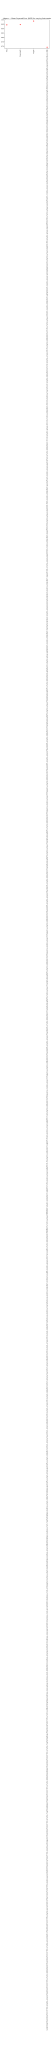

In [243]:
featuresets = [[my_data.columns[ii]] for ii in range(5, 93)]
featuresets = [['freq'], ['freq','length'], ['length'], my_data.columns[3:]]

method      = "ridgecv" # options: "linear" ridge" "ridgecv"

mses = []

for features in featuresets:
    
    this_x_train = my_data[features]

    
    # take log of features (defining log(0)=0)
    # this_x_train = np.where(this_x_train != 0, np.log(this_x_train), 0)
    
    # scale features
    this_x_train = preprocessing.scale(this_x_train)
    
 
    #this_x_test        = preprocessing.scale(np.log(my_data[features]))[255:]
    #mse, r2, coefs = regress(method,this_x_train,y[:255],this_x_test,y[255:],features)
    

    mse, r2, last_coefs      = regress_cv(method,this_x_train,y,features)    
    
    
    print(features)
    print("MSE: ", mse)
    mses.append(mse)
    
    print("coefficients")
    for i, value in enumerate(last_coefs):
        print(features[i], value)
    
x = list(range(len(mses)))
plt.xticks(x, [','.join(f) for f in featuresets], rotation='vertical')
plt.plot(x, mses, 'ro')
plt.title(method+" --- Mean Squared Error (MSE) for varying featuresets")
plt.show()